# Calculate and store the 5-sigma delta mag for a large collection of sources

In [45]:
import os
import re
import sys
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, vstack

sys.path.append('/Users/adamboesky/Research/long_transients')

from Source_Analysis.filter_fields import *
from Extracting.utils import get_n_quadrants_merged, get_n_quadrants_merged_all_fields, load_ecsv

# Plot formatting
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
mpl.rcParams['axes.formatter.use_mathtext'] = True

In [5]:
merged_result_dirpath = '/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/'
result_dirpath = '/Users/adamboesky/Research/long_transients/Data/catalog_results'

In [6]:
get_n_quadrants_merged('000806'), get_n_quadrants_merged_all_fields()

({'g': 0, 'r': 0, 'i': 0}, {'000791': {'g': 55, 'r': 53, 'i': 42}})

In [7]:
# Get n quadrants in each of the combined table
merged_result_dirpath = '/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/'
result_dirpath = '/Users/adamboesky/Research/long_transients/Data/catalog_results'
quad_counts = {}
for merged_fname in os.listdir(merged_result_dirpath):
    field_name = merged_fname.split('.')[0].split('_')[0]
    quad_counts[field_name] = 0
    for dirname in os.listdir(result_dirpath):
        if field_name in dirname:
            quad_counts[field_name] += 1
quad_counts

{'000791': 55}

In [8]:
quad_counts

{'000791': 55}

In [9]:
# # Get 10 square degrees worth of quadrants (~14 quadrants)
# n_quads = 14
# field_dirs = [dirname for dirname in os.listdir(result_dirpath) if re.match(r'\d{6}_\d{2}_\d', dirname) and len(os.listdir(os.path.join(result_dirpath, dirname))) >= 10][:n_quads]
# field_dirs

# The fields that we'll use to get 5-sigma delta mags
# field_names = ['000499', '000806']
field_names = list(quad_counts.keys())
print(f'Fields: {field_names}')
print(f'Area of fields: {len(field_names)} is approximately {np.sum([quad_counts[field_name] for field_name in field_names]) * 0.73} sq degs')

Fields: ['000791']
Area of fields: 1 is approximately 40.15 sq degs


In [10]:
filters = Filters()  # filtering object

def get_prelim_filtered_tabs(field_name: str):

    # Load unfiltered table
    bands = ('g', 'r', 'i')
    tabs = {band: load_ecsv(os.path.join(merged_result_dirpath, f'{field_name}_{band}.ecsv')) for band in bands}

    # Only use sources in both catalogs
    tabs = {band: tab[tab['Catalog_Flag'] == 0] for band, tab in tabs.items()}

    # Print initial table lengths
    for band, tab in tabs.items():
        print(f'Initial length of {band} band table: {len(tab):,}')

    # Drop nan rows
    for band in bands:
        mag_data = tabs[band][[f'PSTARR_{band}PSFMag', f'ZTF_{band}PSFMag']].as_array().view(np.float64).reshape(len(tabs[band]), -1)
        nan_mask = ~np.any(np.isnan(mag_data), axis=1)
        tabs[band] = tabs[band][nan_mask]

    # Apply filters
    filt_names = ['sep_extraction_filter', 'snr_filter', 'shape_filter', 'psf_fit_filter', 'pstarr_not_saturated']
    for filt_name in filt_names:
        print(f'Applying {filt_name} to {field_name}')
        tabs = filters.filter(tabs.copy(), filt_name)

    return tabs

In [11]:
# Get the preliminarily filtered tables for each field
tables = get_prelim_filtered_tabs(field_names[0])
for field_dir in field_names[1:]:
    new_tables = get_prelim_filtered_tabs(field_dir)
    for band in ('g', 'r', 'i'):
        tables[band] = vstack([tables[band], new_tables[band]])

Initial length of g band table: 614,304
Initial length of r band table: 892,197
Initial length of i band table: 771,910
Applying sep_extraction_filter to 000791
Applying snr_filter to 000791


/Users/adamboesky/Research/long_transients/Extracting/utils.py:50: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


Applying shape_filter to 000791
Applying psf_fit_filter to 000791
Applying pstarr_not_saturated to 000791


In [12]:
for band, tab in tables.items():
    print(f'Length of {band} band table: {len(tab):,}')

Length of g band table: 329,371
Length of r band table: 456,737
Length of i band table: 458,060


In [10]:
# Get the 5-sigma boudnds
dmag_sigma = 5
outside_5sigma_tables, bin_means, bin_stds = filters.filter(tables.copy(), 'only_big_dmag', mag_thresh=dmag_sigma)

/Users/adamboesky/Research/long_transients/Source_Analysis/filter_fields.py:507: RuntimeWarning: Mean of empty slice
  bin_means[band].append(np.nanmean(ztf_mags[bin_mask] - pstarr_mags[bin_mask]))
/Users/adamboesky/opt/anaconda3/envs/long_transients/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


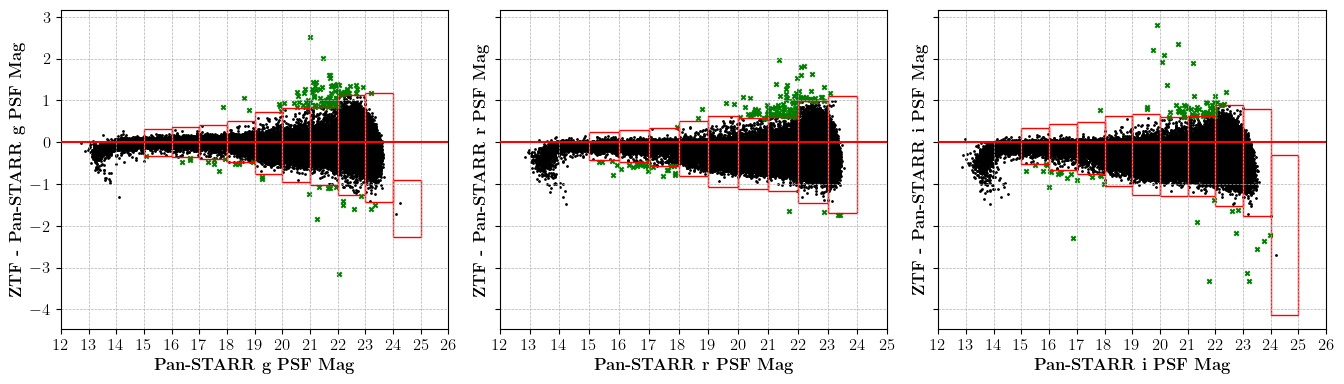

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(13.6, 4), sharey=True)

bin_means = {}
bin_stds = {}
outside_masks = {}
for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]
    outside_masks[band] = np.ones(len(tab), dtype=bool)

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog_Flag'] == 0) & (tab[f'PSTARR_{band}PSFMag'] != -999)
    outside_masks[band] &= both_mask

    # Get the 3-sigma boundaries on delta mag
    min_mag = 15.0
    mag_bin_edges = np.arange(min_mag, np.nanmax(tab[f'PSTARR_{band}PSFMag']) + 1, step=1)
    bin_means[band], bin_stds[band] = [], []
    for i in range(len(mag_bin_edges) - 1):
        lower, upper = mag_bin_edges[i], mag_bin_edges[i+1]
        bin_mask = both_mask & (tab[f'PSTARR_{band}PSFMag'] >= lower) & (tab[f'PSTARR_{band}PSFMag'] < upper)
        bin_means[band].append(np.nanmean(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))
        bin_stds[band].append(np.nanstd(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))

        both_mask = (tab['Catalog_Flag'] == 0) & (tab[f'PSTARR_{band}PSFMag'] != -999)
        gtr_mag_min_mask = tab[f'PSTARR_{band}PSFMag'] > min_mag
        outside_masks[band][bin_mask] = np.abs(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"] - bin_means[band][-1]) > 5 * bin_stds[band][-1]
        outside_masks[band] &= both_mask
        outside_masks[band] &= gtr_mag_min_mask  # ignore anything less than some magnitude

    # Plot
    ax.scatter(
        tab[both_mask][f'PSTARR_{band}PSFMag'],
        tab[both_mask][f'ZTF_{band}PSFMag'] - tab[both_mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )
    ax.scatter(
        tab[outside_masks[band]][f'PSTARR_{band}PSFMag'],
        tab[outside_masks[band]][f'ZTF_{band}PSFMag'] - tab[outside_masks[band]][f'PSTARR_{band}PSFMag'],
        color='green',
        marker='x',
        s=10,
    )

    # Plot the bin mean +- 3sigma with rectangles for each bin
    for lower, upper, mean, std in zip(mag_bin_edges[:-1], mag_bin_edges[1:], bin_means[band], bin_stds[band]):
        rect = plt.Rectangle(
            (lower, mean - (5 * std)),
            upper - lower,
            10 * std,
            color='red',
            lw=1.0,
            fc="none",
        )
        ax.add_patch(rect)

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(rf'\bf{{ZTF - Pan-STARR {band} PSF Mag}}')
    ax.set_xlabel(rf'\bf{{Pan-STARR {band} PSF Mag}}')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_xticks(np.arange(np.floor(ax.get_xlim()[0]), np.ceil(ax.get_xlim()[1]) + 1, 1))
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/long_transients/Figures/dmag_scatter.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Store 5-sigma delta mags
delta_mag_5sigma = {'means': bin_means, 'stds': bin_stds}
# with open('/Users/adamboesky/Research/long_transients/Data/5sigma_delta_mags.pkl', 'wb') as f:
#     pickle.dump(delta_mag_5sigma, f)

# Using a KDE

In [13]:
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

In [14]:
xgrid = np.linspace(11, 25, 100)
ygrid = np.linspace(-5, 5, 100)
Zs = {}
kdes = {}
for band in ('g', 'r', 'i'):

    # Get the data
    print('Fetching data...')
    tab = tables[band]
    x = tab[f'PSTARR_{band}PSFMag']
    y = tab[f'ZTF_{band}PSFMag'] - tab[f'PSTARR_{band}PSFMag']

    # Create KDE object
    print('Calculating the KDE...')
    xy = np.vstack([x, y])
    kdes[band] = gaussian_kde(xy)

    # Evaluate KDE on grid
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Zs[band] = np.reshape(kdes[band](positions).T, X.shape)

Fetching data...
Calculating the KDE...
Fetching data...
Calculating the KDE...
Fetching data...
Calculating the KDE...


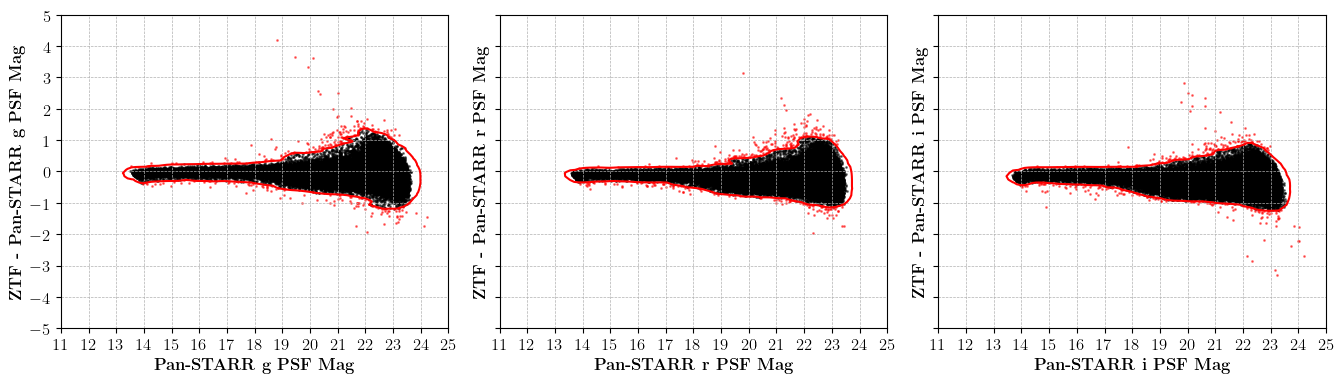

In [ ]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(13.6, 4), sharey=True)
for ax, band in zip(axes, ('g', 'r', 'i')):

    contour = ax.contour(X, Y, Zs[band], colors='red', levels=[0.0005])

    # Get points outside the contour
    path = contour.get_paths()[0]
    mask = path.contains_points(
        np.vstack((
            tables[band][f'PSTARR_{band}PSFMag'],
            tables[band][f'ZTF_{band}PSFMag'] - tables[band][f'PSTARR_{band}PSFMag'],
        )).T,
    )

    # Plot points
    ax.scatter(
        tables[band][f'PSTARR_{band}PSFMag'][mask],
        tables[band][f'ZTF_{band}PSFMag'][mask] - tables[band][f'PSTARR_{band}PSFMag'][mask],
        s=1,
        color='k',
        alpha=0.5,
        zorder=-1,
    )
    ax.scatter(
        tables[band][f'PSTARR_{band}PSFMag'][~mask],
        tables[band][f'ZTF_{band}PSFMag'][~mask] - tables[band][f'PSTARR_{band}PSFMag'][~mask],
        s=1,
        color='red',
        alpha=0.5,
    )

    ax.set_ylabel(rf'\bf{{ZTF - Pan-STARR {band} PSF Mag}}')
    ax.set_xlabel(rf'\bf{{Pan-STARR {band} PSF Mag}}')
    ax.grid(lw=0.5, ls='--')

for ax in axes:
    ax.set_xticks(np.arange(np.floor(ax.get_xlim()[0]), np.ceil(ax.get_xlim()[1]) + 1, 1))
    ax.set_yticks(np.arange(np.floor(ax.get_ylim()[0]), np.ceil(ax.get_ylim()[1]) + 1, 1))

axes[-1].set_xlim((11, 25))
ax.set_ylim(-5, 5)

plt.tight_layout()

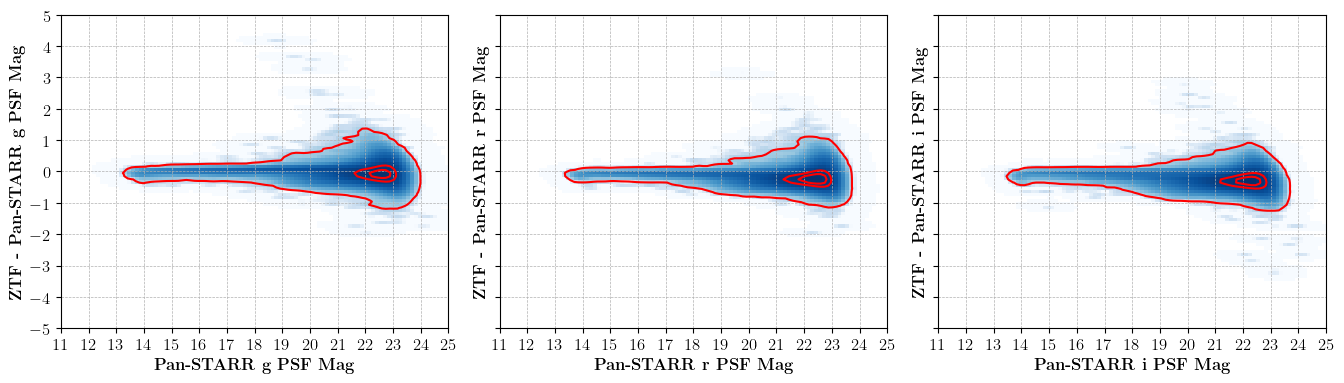

In [44]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(13.6, 4), sharey=True)
for ax, band in zip(axes, ('g', 'r', 'i')):
    ax.imshow(
        Zs[band], origin='lower', aspect='auto',
        extent=[xgrid.min(), xgrid.max(), ygrid.min(), ygrid.max()],
        cmap='Blues',
        norm=LogNorm(vmin=1E-5),
    )
    ax.contour(X, Y, Zs[band], colors='red', levels=[0.0005, 0.5, 0.75, 0.99])
    ax.set_ylabel(rf'\bf{{ZTF - Pan-STARR {band} PSF Mag}}')
    ax.set_xlabel(rf'\bf{{Pan-STARR {band} PSF Mag}}')

    ax.grid(lw=0.5, ls='--')

for ax in axes:
    ax.set_xticks(np.arange(np.floor(ax.get_xlim()[0]), np.ceil(ax.get_xlim()[1]) + 1, 1))
    ax.set_yticks(np.arange(np.floor(ax.get_ylim()[0]), np.ceil(ax.get_ylim()[1]) + 1, 1))

axes[-1].set_xlim((11, 25))
ax.set_ylim(-5, 5)

plt.tight_layout()